In [ ]:
!pip install pandas polars numpy matplotlib

1) Claude Full Running

Starting Pandas vs Polars Performance Benchmark

Benchmarking with 10,000 rows and 10 columns...
Generating dataset with 10,000 rows and 10 columns using batches of 100,000...
  Generating batch 1/1 (10,000 rows)...
Dataset generation complete. Files saved to C:\Users\ADMINI~1\AppData\Local\Temp\2\tmprmaue7ke
Generating dataset with 1,000 rows and 10 columns using batches of 100,000...
  Generating batch 1/1 (1,000 rows)...
Dataset generation complete. Files saved to C:\Users\ADMINI~1\AppData\Local\Temp\2\tmprmaue7ke
Running benchmarks...
Running Pandas filter...
Running Pandas groupby...
Running Pandas window operations...
Running Pandas sort...
Running Pandas join...
Measuring Pandas memory consumption...
Running Polars filter...
Running Polars groupby...
Running Polars window operations...
Running Polars sort...
Running Polars join...
Measuring Polars memory consumption...

Benchmarking with 100,000 rows and 10 columns...
Generating dataset with 100,000 rows and 10 columns using bat

IndexError: single positional indexer is out-of-bounds

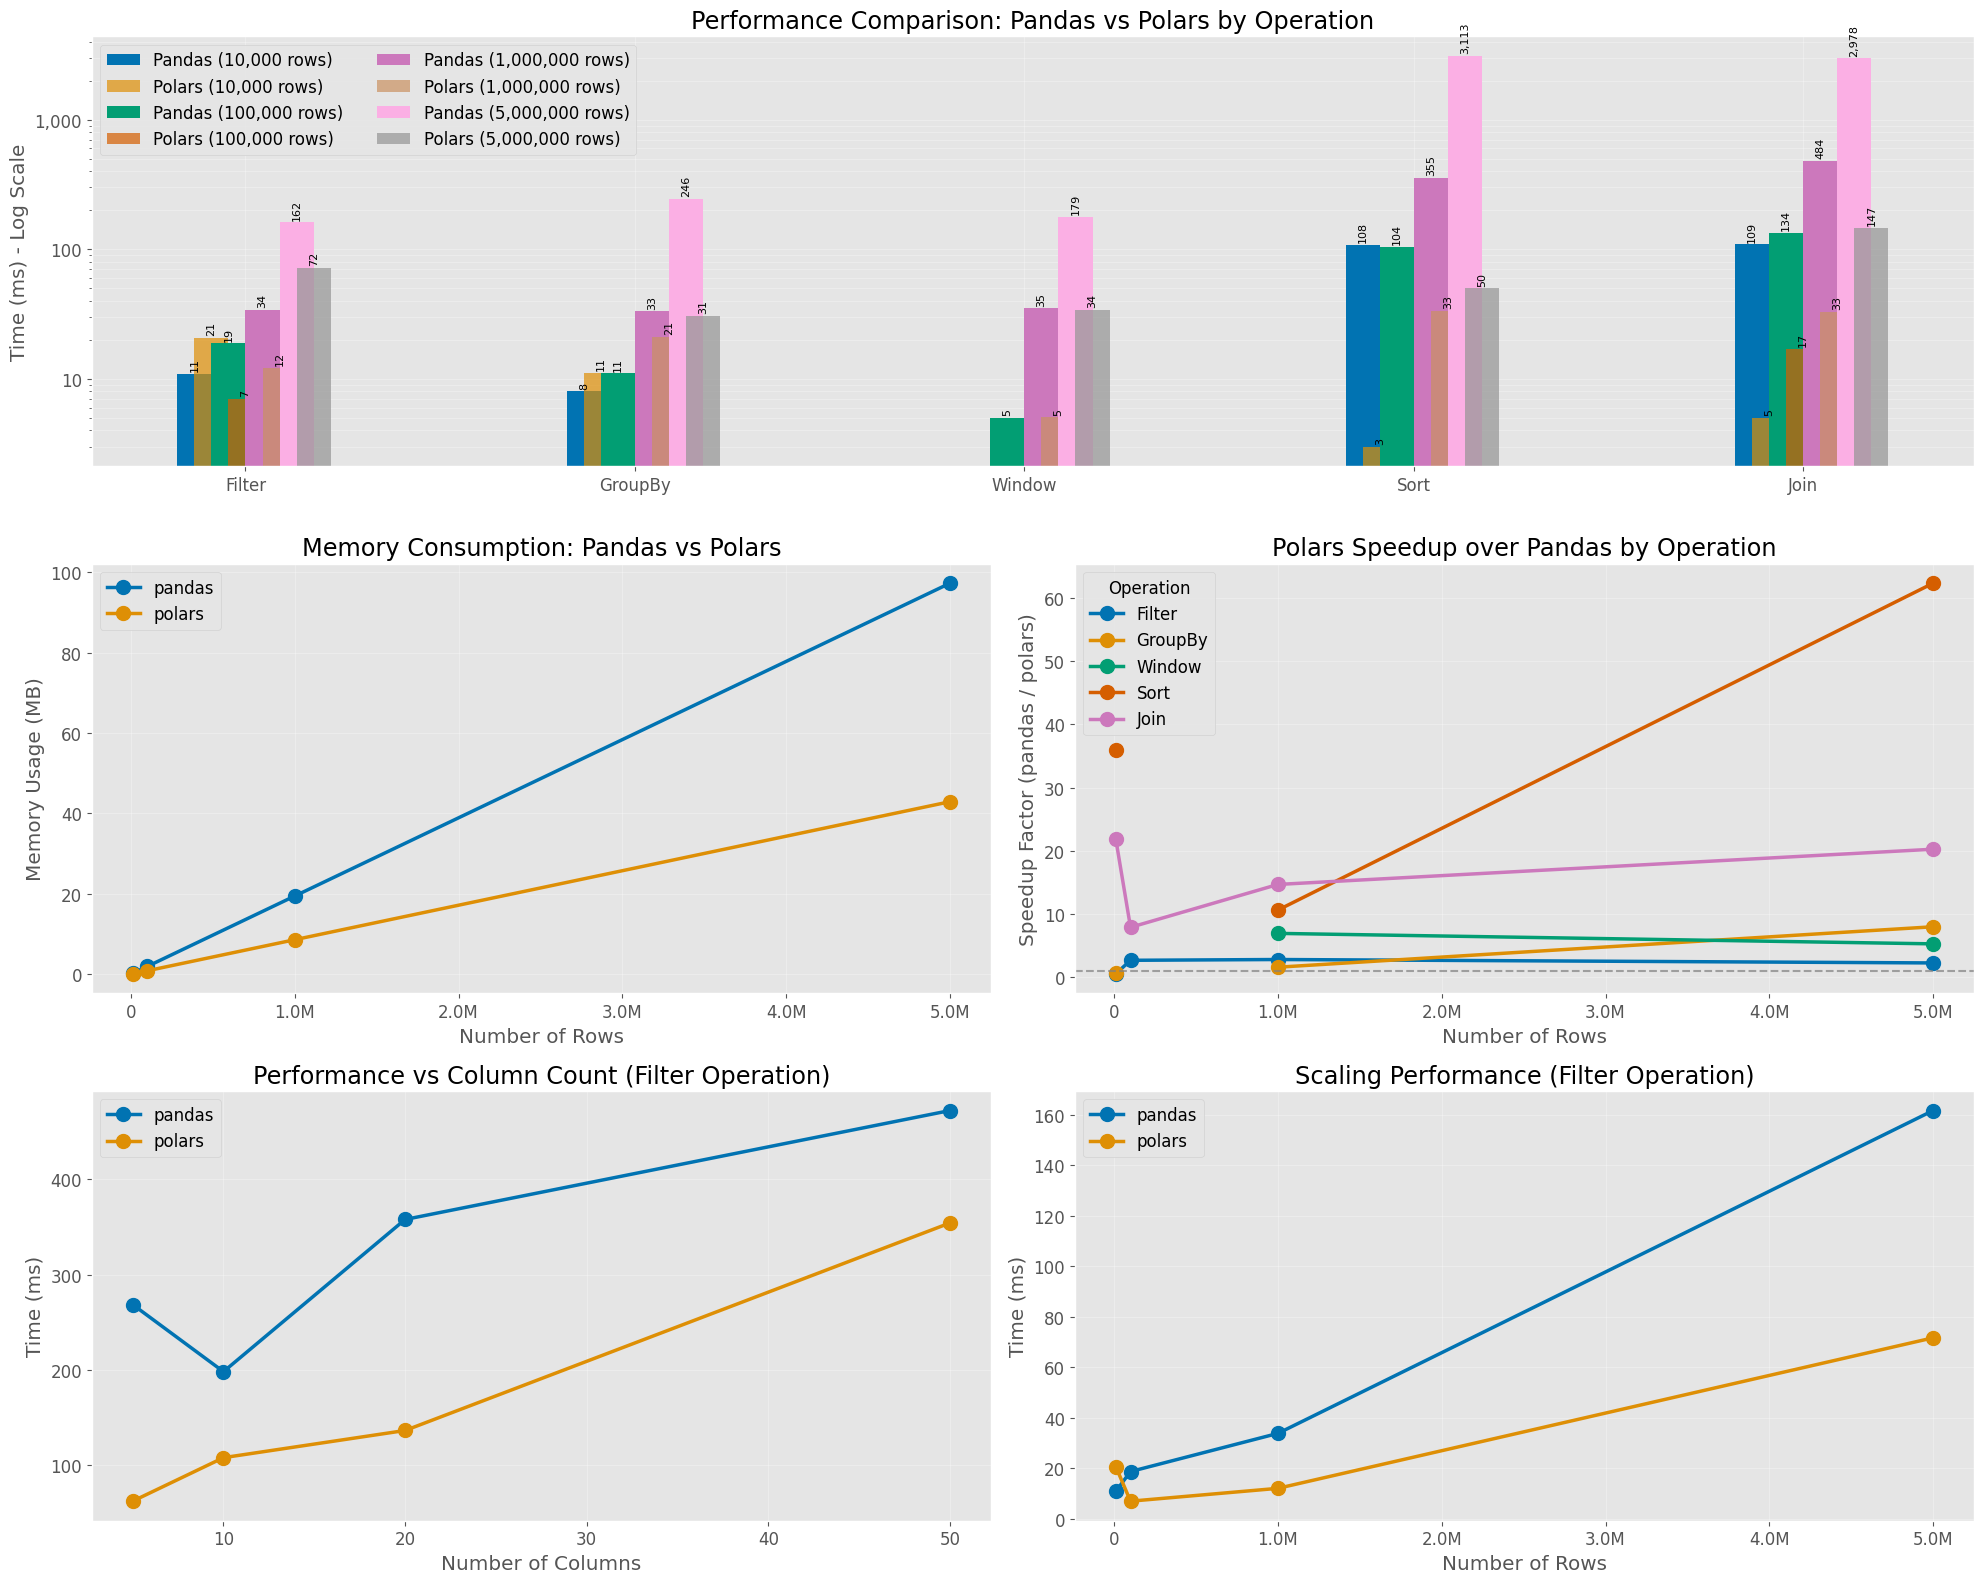

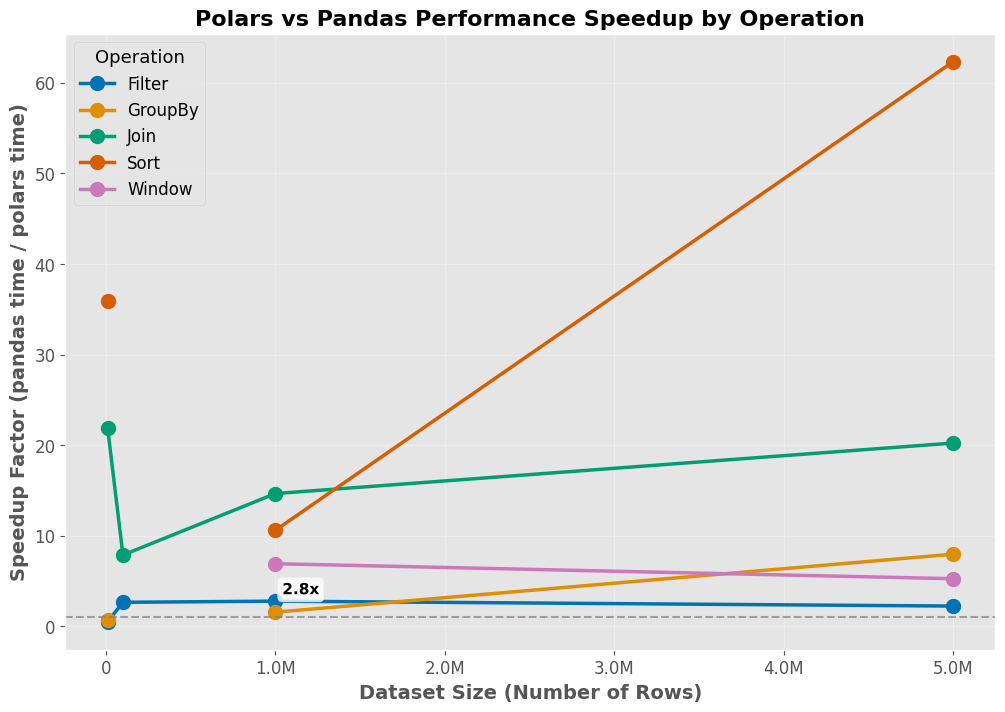

In [5]:
import pandas as pd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
import gc
import os
import tempfile
import shutil
import pyarrow.parquet as pq
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as path_effects

# Set better visual style
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Define a timer decorator for measuring execution time
def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        gc.collect()  # Force garbage collection before timing
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = (end_time - start_time) * 1000  # Convert to milliseconds
        return result, execution_time
    return wrapper

# Helper function to read Parquet files in batches using PyArrow
def read_parquet_batches(file_path, batch_size):
    pf = pq.ParquetFile(file_path)
    for batch in pf.iter_batches(batch_size=batch_size):
        yield batch.to_pandas()

# Function to generate a random dataset in batches
def generate_dataset_batched(rows, cols, batch_size=100000, temp_dir=None):
    """Generate a random dataset with specified dimensions in batches to save memory"""
    print(f"Generating dataset with {rows:,} rows and {cols} columns using batches of {batch_size:,}...")
    
    # Create temporary files for pandas and polars
    if temp_dir is None:
        temp_dir = tempfile.mkdtemp()
    
    pandas_file = os.path.join(temp_dir, "pandas_data.parquet")
    polars_file = os.path.join(temp_dir, "polars_data.parquet")
    
    # Create column names
    col_names = [f'col_{i}' for i in range(cols)]
    
    # Define a safe modulo value to avoid OutOfBoundsDatetime error
    max_days = 80000  # Ensure that dates never exceed the maximum representable Timestamp
    
    # Generate data in batches
    num_batches = (rows + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, rows)
        batch_size_actual = batch_end - batch_start
        
        print(f"  Generating batch {batch_idx + 1}/{num_batches} ({batch_size_actual:,} rows)...")
        
        # Generate numeric data for this batch
        data = np.random.randn(batch_size_actual, cols)
        
        # Create pandas DataFrame for this batch
        df_batch = pd.DataFrame(data, columns=col_names)
        
        # Add categorical columns
        df_batch['cat1'] = np.random.choice(['A', 'B', 'C', 'D'], size=batch_size_actual)
        df_batch['cat2'] = np.random.choice(['X', 'Y', 'Z'], size=batch_size_actual)
        
        # Add date column using modulo arithmetic to keep dates within bounds
        day_offsets = np.arange(batch_start, batch_end) % max_days
        df_batch['date'] = pd.to_datetime(day_offsets, unit='D', origin='2020-01-01')
        
        # Write to files
        if batch_idx == 0:
            df_batch.to_parquet(pandas_file, index=False)
            pl.from_pandas(df_batch).write_parquet(polars_file)
        else:
            # Use fastparquet engine for append mode
            df_batch.to_parquet(pandas_file, engine='fastparquet', append=True, index=False)
            
            # For polars, read existing data and concatenate with new batch
            try:
                existing = pl.read_parquet(polars_file)
                pl.concat([existing, pl.from_pandas(df_batch)]).write_parquet(polars_file)
            except Exception as e:
                print(f"Error appending to polars file: {e}")
                # Fallback: just write the current batch
                pl.from_pandas(df_batch).write_parquet(polars_file)
        
        # Clean up to free memory
        del df_batch, data
        gc.collect()
    
    print(f"Dataset generation complete. Files saved to {temp_dir}")
    return pandas_file, polars_file

# Benchmark functions for pandas with batched processing
@timer
def pandas_filter_batched(file_path, batch_size=100000):
    filtered_rows = 0
    for batch in read_parquet_batches(file_path, batch_size):
        filtered_batch = batch[batch['col_0'] > 0]
        filtered_rows += len(filtered_batch)
    return filtered_rows

@timer
def pandas_groupby_agg_batched(file_path, batch_size=100000):
    group_stats = {}
    for batch in read_parquet_batches(file_path, batch_size):
        batch_groups = batch.groupby(['cat1', 'cat2']).agg({
            'col_0': ['count', 'sum'],
            'col_1': ['sum'],
            'col_2': ['max']
        })
        for group_key, group_data in batch_groups.iterrows():
            if group_key not in group_stats:
                group_stats[group_key] = {
                    'col_0_count': 0,
                    'col_0_sum': 0,
                    'col_1_sum': 0,
                    'col_2_max': float('-inf')
                }
            group_stats[group_key]['col_0_count'] += group_data[('col_0', 'count')]
            group_stats[group_key]['col_0_sum'] += group_data[('col_0', 'sum')]
            group_stats[group_key]['col_1_sum'] += group_data[('col_1', 'sum')]
            group_stats[group_key]['col_2_max'] = max(
                group_stats[group_key]['col_2_max'],
                group_data[('col_2', 'max')]
            )
    result = []
    for group_key, stats in group_stats.items():
        mean_col_0 = stats['col_0_sum'] / stats['col_0_count'] if stats['col_0_count'] > 0 else None
        result.append({
            'cat1': group_key[0],
            'cat2': group_key[1],
            'col_0_mean': mean_col_0,
            'col_1_sum': stats['col_1_sum'],
            'col_2_max': stats['col_2_max']
        })
    return pd.DataFrame(result)

@timer
def pandas_window_op_batched(file_path, batch_size=100000):
    processed_rows = 0
    window_size = 10
    buffer = pd.DataFrame()
    for batch in read_parquet_batches(file_path, batch_size):
        combined = pd.concat([buffer, batch])
        combined['rolling_mean'] = combined['col_0'].rolling(window=window_size).mean()
        valid_rows = combined.iloc[window_size-1:]
        processed_rows += len(valid_rows)
        buffer = combined.iloc[-window_size+1:] if len(combined) >= window_size else combined
    return processed_rows

@timer
def pandas_sort_batched(file_path, batch_size=100000):
    try:
        temp_dir = tempfile.mkdtemp()
        sorted_files = []
        for i, batch in enumerate(read_parquet_batches(file_path, batch_size)):
            sorted_batch = batch.sort_values(by=['col_0', 'col_1'])
            batch_file = os.path.join(temp_dir, f"sorted_batch_{i}.parquet")
            sorted_batch.to_parquet(batch_file, index=False)
            sorted_files.append(batch_file)
            del batch, sorted_batch
            gc.collect()
        merged_dfs = []
        for file in sorted_files:
            batch = pd.read_parquet(file)
            merged_dfs.append(batch)
            if len(merged_dfs) >= 3:
                merged = pd.concat(merged_dfs).sort_values(by=['col_0', 'col_1'])
                merged_dfs = [merged]
                gc.collect()
        if merged_dfs:
            result = pd.concat(merged_dfs).sort_values(by=['col_0', 'col_1'])
            row_count = len(result)
        else:
            row_count = 0
        shutil.rmtree(temp_dir, ignore_errors=True)
        return row_count
    except Exception as e:
        print(f"Error in pandas_sort_batched: {e}")
        return 0

# Add new pandas join benchmark
@timer
def pandas_join_batched(main_file, small_file, batch_size=100000):
    try:
        temp_dir = tempfile.mkdtemp()
        joined_files = []
        small_df = pd.read_parquet(small_file)
        
        for i, batch in enumerate(read_parquet_batches(main_file, batch_size)):
            # Join with small dataset
            joined_batch = batch.merge(small_df, on='col_0', how='inner', suffixes=('', '_small'))
            batch_file = os.path.join(temp_dir, f"joined_batch_{i}.parquet")
            joined_batch.to_parquet(batch_file, index=False)
            joined_files.append(batch_file)
            del batch, joined_batch
            gc.collect()
            
        result_count = sum(len(pd.read_parquet(file)) for file in joined_files)
        shutil.rmtree(temp_dir, ignore_errors=True)
        return result_count
    except Exception as e:
        print(f"Error in pandas_join_batched: {e}")
        return 0

# Benchmark functions for polars with batched processing
@timer
def polars_filter_batched(file_path):
    result = pl.scan_parquet(file_path).filter(pl.col('col_0') > 0).collect()
    return len(result)

@timer
def polars_groupby_agg_batched(file_path):
    result = (
        pl.scan_parquet(file_path)
        .group_by(['cat1', 'cat2'])
        .agg([
            pl.col('col_0').mean(),
            pl.col('col_1').sum(),
            pl.col('col_2').max()
        ])
        .collect()
    )
    return result

@timer
def polars_window_op_batched(file_path):
    result = (
        pl.scan_parquet(file_path)
        .with_columns(
            pl.col('col_0').rolling_mean(window_size=10).alias('rolling_mean')
        )
        .collect()
    )
    return len(result)

@timer
def polars_sort_batched(file_path):
    result = pl.scan_parquet(file_path).sort(['col_0', 'col_1']).collect()
    return len(result)

# Add new polars join benchmark
@timer
def polars_join_batched(main_file, small_file):
    main_df = pl.scan_parquet(main_file)
    small_df = pl.scan_parquet(small_file)
    result = main_df.join(small_df, on='col_0', how='inner', suffix='_small').collect()
    return len(result)

# Run memory profiling
@timer
def pandas_memory_consumption(file_path):
    df = pd.read_parquet(file_path)
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
    return memory_usage

@timer
def polars_memory_consumption(file_path):
    df = pl.read_parquet(file_path)
    memory_usage = df.estimated_size() / (1024 * 1024)  # MB
    return memory_usage

# Run benchmarks and collect results
def run_benchmarks_batched(rows_list, cols, batch_size=100000):
    results = {
        'operation': [],
        'library': [],
        'rows': [],
        'time_ms': [],
        'memory_mb': []
    }
    
    # Add test for various column counts
    column_results = {
        'operation': [],
        'library': [],
        'columns': [],
        'time_ms': []
    }
    
    # Add scaling test
    scaling_results = {
        'operation': 'Filter',
        'library': [],
        'rows': [],
        'time_ms': []
    }
    
    temp_dir = tempfile.mkdtemp()
    
    # Run benchmarks for different row counts
    for rows in rows_list:
        print(f"\nBenchmarking with {rows:,} rows and {cols} columns...")
        pandas_file, polars_file = generate_dataset_batched(rows, cols, batch_size, temp_dir)
        
        # Create a smaller dataset for join operations
        small_rows = min(rows // 10, 1_000_000)
        small_pandas_file, small_polars_file = generate_dataset_batched(small_rows, cols, batch_size, temp_dir)
        
        print("Running benchmarks...")
        print("Running Pandas filter...")
        _, time_pandas_filter = pandas_filter_batched(pandas_file, batch_size)
        print("Running Pandas groupby...")
        _, time_pandas_groupby = pandas_groupby_agg_batched(pandas_file, batch_size)
        print("Running Pandas window operations...")
        _, time_pandas_window = pandas_window_op_batched(pandas_file, batch_size)
        print("Running Pandas sort...")
        _, time_pandas_sort = pandas_sort_batched(pandas_file, batch_size)
        print("Running Pandas join...")
        _, time_pandas_join = pandas_join_batched(pandas_file, small_pandas_file, batch_size)
        print("Measuring Pandas memory consumption...")
        memory_pandas, _ = pandas_memory_consumption(pandas_file)
        
        print("Running Polars filter...")
        _, time_polars_filter = polars_filter_batched(polars_file)
        print("Running Polars groupby...")
        _, time_polars_groupby = polars_groupby_agg_batched(polars_file)
        print("Running Polars window operations...")
        _, time_polars_window = polars_window_op_batched(polars_file)
        print("Running Polars sort...")
        _, time_polars_sort = polars_sort_batched(polars_file)
        print("Running Polars join...")
        _, time_polars_join = polars_join_batched(polars_file, small_polars_file)
        print("Measuring Polars memory consumption...")
        
        memory_polars, _ = polars_memory_consumption(polars_file)

        # Add results to dictionary
        operations = ['Filter', 'GroupBy', 'Window', 'Sort', 'Join']
        pandas_times = [time_pandas_filter, time_pandas_groupby, time_pandas_window, time_pandas_sort, time_pandas_join]
        polars_times = [time_polars_filter, time_polars_groupby, time_polars_window, time_polars_sort, time_polars_join]
        
        for i, op in enumerate(operations):
            results['operation'].append(op)
            results['library'].append('pandas')
            results['rows'].append(rows)
            results['time_ms'].append(pandas_times[i])
            results['memory_mb'].append(memory_pandas)
            
            results['operation'].append(op)
            results['library'].append('polars')
            results['rows'].append(rows)
            results['time_ms'].append(polars_times[i])
            results['memory_mb'].append(memory_polars)
        
        # Add to scaling results for filter operation specifically
        scaling_results['library'].extend(['pandas', 'polars'])
        scaling_results['rows'].extend([rows, rows])
        scaling_results['time_ms'].extend([time_pandas_filter, time_polars_filter])
        
    # Clean up temporary files
    try:
        shutil.rmtree(temp_dir, ignore_errors=True)
    except Exception as e:
        print(f"Warning: Could not clean up temporary directory: {e}")
    
    results_df = pd.DataFrame(results)
    scaling_df = pd.DataFrame({k: v for k, v in scaling_results.items() if len(v) > 0})
    
    return results_df, scaling_df

# Function to generate column count benchmark data
def benchmark_column_variations(rows=1_000_000, col_counts=[10, 20, 50, 100], batch_size=100000):
    col_results = {
        'operation': [],
        'library': [],
        'columns': [],
        'time_ms': []
    }
    
    temp_dir = tempfile.mkdtemp()
    
    # Run benchmarks for different column counts
    for cols in col_counts:
        print(f"\nBenchmarking column variation with {rows:,} rows and {cols} columns...")
        pandas_file, polars_file = generate_dataset_batched(rows, cols, batch_size, temp_dir)
        
        print("Running Pandas filter...")
        _, time_pandas_filter = pandas_filter_batched(pandas_file, batch_size)
        print("Running Polars filter...")
        _, time_polars_filter = polars_filter_batched(polars_file)
        
        col_results['operation'].extend(['Filter', 'Filter'])
        col_results['library'].extend(['pandas', 'polars'])
        col_results['columns'].extend([cols, cols])
        col_results['time_ms'].extend([time_pandas_filter, time_polars_filter])
    
    # Clean up temporary files
    try:
        shutil.rmtree(temp_dir, ignore_errors=True)
    except Exception as e:
        print(f"Warning: Could not clean up temporary directory: {e}")
    
    return pd.DataFrame(col_results)

# Function to format numbers in thousands
def thousands_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    return f'{x/1_000:.0f}K' if x >= 1_000 else str(int(x))

# Function to create speedup visualization
def visualize_speedup(results_df):
    # Pivot data to calculate speedup
    pivot_df = results_df.pivot_table(
        index=['operation', 'rows'],
        columns='library',
        values='time_ms'
    ).reset_index()
    
    # Calculate speedup (pandas / polars)
    pivot_df['speedup'] = pivot_df['pandas'] / pivot_df['polars']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    operations = pivot_df['operation'].unique()
    colors = sns.color_palette("colorblind", len(operations))
    
    for i, op in enumerate(operations):
        op_data = pivot_df[pivot_df['operation'] == op]
        ax.plot(op_data['rows'], op_data['speedup'], 'o-', label=op, color=colors[i], linewidth=2.5, markersize=10)
    
    # Add reference line for speedup = 1
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
    
    # Add labels and formatting
    ax.set_xlabel('Dataset Size (Number of Rows)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Speedup Factor (pandas time / polars time)', fontsize=14, fontweight='bold')
    ax.set_title('Polars vs Pandas Performance Speedup by Operation', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(title='Operation', fontsize=12, title_fontsize=13)
    
    # Format x-axis with thousands separator
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Add annotations for highest speedups
    for op in operations:
        op_data = pivot_df[pivot_df['operation'] == op]
        # Only add annotation if we have data for this operation
        if not op_data.empty and op_data['speedup'].notna().any():
            max_idx = op_data['speedup'].idxmax()
            if max_idx in op_data.index:  # Ensure the index exists
                max_row = op_data.loc[max_idx]
                
                # Add annotation with outline for better visibility
                txt = ax.annotate(
                    f"{max_row['speedup']:.1f}x",
                    (max_row['rows'], max_row['speedup']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=11,
                    fontweight='bold',
                    color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
                )
                txt.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
    
    plt.tight_layout()
    return fig

# Function to visualize benchmark results
def visualize_results(results_df, column_df=None, scaling_df=None):
    # Create main figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 2, figure=fig)
    
    # Bar chart comparison for each operation
    ax1 = fig.add_subplot(gs[0, :])
    pivot_data = results_df.pivot_table(
        index=['operation', 'rows'],
        columns='library',
        values='time_ms'
    ).reset_index()
    
    # Plot grouped bar chart
    unique_rows = sorted(results_df['rows'].unique())
    unique_ops = results_df['operation'].unique()
    x = np.arange(len(unique_ops))
    width = 0.35 / len(unique_rows)
    
    for i, rows in enumerate(unique_rows):
        offset = (i - len(unique_rows)/2 + 0.5) * width
        subset = pivot_data[pivot_data['rows'] == rows]
        pandas_times = [subset[subset['operation'] == op]['pandas'].values[0] if not subset[subset['operation'] == op].empty else 0 for op in unique_ops]
        polars_times = [subset[subset['operation'] == op]['polars'].values[0] if not subset[subset['operation'] == op].empty else 0 for op in unique_ops]
        
        ax1.bar(x + offset, pandas_times, width, label=f'Pandas ({rows:,} rows)')
        ax1.bar(x + offset + width/2, polars_times, width, label=f'Polars ({rows:,} rows)', alpha=0.7)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(unique_ops)
    ax1.set_yscale('log')
    ax1.set_ylabel('Time (ms) - Log Scale')
    ax1.set_title('Performance Comparison: Pandas vs Polars by Operation')
    ax1.legend(loc='upper left', ncol=2)
    ax1.grid(True, alpha=0.3, which='both')
    
    # Format y-axis with thousands separator
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add value labels on bars
    for bar in ax1.patches:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height * 1.05,
                f'{height:,.0f}',
                ha='center',
                va='bottom',
                rotation=90,
                fontsize=8
            )
    
    # Memory usage comparison
    ax2 = fig.add_subplot(gs[1, 0])
    memory_data = results_df.drop_duplicates(subset=['library', 'rows'])[['library', 'rows', 'memory_mb']]
    
    for lib in ['pandas', 'polars']:
        lib_data = memory_data[memory_data['library'] == lib]
        ax2.plot(lib_data['rows'], lib_data['memory_mb'], 'o-', label=lib, linewidth=2.5, markersize=10)
    
    ax2.set_xlabel('Number of Rows')
    ax2.set_ylabel('Memory Usage (MB)')
    ax2.set_title('Memory Consumption: Pandas vs Polars')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Format axes with thousands separator
    ax2.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Speedup plot
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Group by operation and rows
    speedup_data = pivot_data.copy()
    speedup_data['speedup'] = speedup_data['pandas'] / speedup_data['polars']
    
    for op in unique_ops:
        op_data = speedup_data[speedup_data['operation'] == op]
        ax3.plot(op_data['rows'], op_data['speedup'], 'o-', label=op, linewidth=2.5, markersize=10)
    
    ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Number of Rows')
    ax3.set_ylabel('Speedup Factor (pandas / polars)')
    ax3.set_title('Polars Speedup over Pandas by Operation')
    ax3.legend(title='Operation')
    ax3.grid(True, alpha=0.3)
    
    # Format x-axis with thousands separator
    ax3.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Column variation plot (if available)
    if column_df is not None and not column_df.empty:
        ax4 = fig.add_subplot(gs[2, 0])
        
        pivot_col = column_df.pivot_table(
            index='columns',
            columns='library',
            values='time_ms'
        ).reset_index()
        
        for lib in ['pandas', 'polars']:
            ax4.plot(pivot_col['columns'], pivot_col[lib], 'o-', label=lib, linewidth=2.5, markersize=10)
        
        ax4.set_xlabel('Number of Columns')
        ax4.set_ylabel('Time (ms)')
        ax4.set_title('Performance vs Column Count (Filter Operation)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # Scaling plot (if available)
    if scaling_df is not None and not scaling_df.empty:
        ax5 = fig.add_subplot(gs[2, 1])
        
        for lib in ['pandas', 'polars']:
            lib_data = scaling_df[scaling_df['library'] == lib]
            ax5.plot(lib_data['rows'], lib_data['time_ms'], 'o-', label=lib, linewidth=2.5, markersize=10)
        
        ax5.set_xlabel('Number of Rows')
        ax5.set_ylabel('Time (ms)')
        ax5.set_title('Scaling Performance (Filter Operation)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Format x-axis with thousands separator
        ax5.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    plt.tight_layout()
    return fig

# Main execution function
def main():
    print("Starting Pandas vs Polars Performance Benchmark")
    
    # Define benchmark parameters
    rows_list = [10_000, 100_000, 1_000_000, 5_000_000]  # Rows to test
    cols = 10  # Number of columns
    batch_size = 100_000  # Batch size for processing
    
    # Run row count benchmarks
    results_df, scaling_df = run_benchmarks_batched(rows_list, cols, batch_size)
    
    # Run column count benchmarks
    col_results_df = benchmark_column_variations(rows=1_000_000, col_counts=[5, 10, 20, 50], batch_size=batch_size)
    
    # Create visualizations
    fig_main = visualize_results(results_df, col_results_df, scaling_df)
    fig_speedup = visualize_speedup(results_df)
    
    # Save results
    print("Saving results...")
    results_df.to_csv('benchmark_results.csv', index=False)
    col_results_df.to_csv('column_benchmark_results.csv', index=False)
    scaling_df.to_csv('scaling_benchmark_results.csv', index=False)
    
    # Save visualizations
    fig_main.savefig('benchmark_results.png', dpi=300, bbox_inches='tight')
    fig_speedup.savefig('speedup_comparison.png', dpi=300, bbox_inches='tight')
    
    print("Benchmark complete! Results saved to CSV files and visualizations saved as PNG.")
    
    # Display summary
    print("\nSummary:")
    print("Average speedup by operation:")
    pivot_summary = results_df.pivot_table(
        index='operation',
        columns='library',
        values='time_ms',
        aggfunc='mean'
    )
    pivot_summary['speedup'] = pivot_summary['pandas'] / pivot_summary['polars']
    print(pivot_summary)

    # Return the DataFrame for further analysis
    return results_df, col_results_df, scaling_df

if __name__ == "__main__":
    main()